In [ ]:
# 1. Standard library imports
import os
import warnings

# Configuration: Set environment variables before importing PyMC/PyTensor
os.environ["PYTENSOR_FLAGS"] = "cxx=" 
warnings.filterwarnings('ignore')

# 2. Third-party imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats

# Dataset Creation

In [21]:
df = pd.read_csv('ticino_temperature_2025.csv')

In [22]:
df.head()

,station,year,month,temperature,latitude,longitude,altitude,season
0,Airolo,2025,1,-1.2,46.5286,8.6111,1175.0,0
1,Airolo,2025,2,0.5,46.5286,8.6111,1175.0,0
2,Airolo,2025,3,3.7,46.5286,8.6111,1175.0,1
3,Airolo,2025,4,8.7,46.5286,8.6111,1175.0,1
4,Airolo,2025,5,11.7,46.5286,8.6111,1175.0,1


# ❄️ Bayesian Hypothesis Test: Latitude Effect on Winter Temperatures

## Research Question

Does temperature vary significantly between Northern and Southern stations in Ticino during the Winter of 2025?

Hypothesis Formulation

**Null Hypothesis ($H_0$)**: The mean temperature in Winter (Dec, Jan, Feb) is equal across Southern (Low Latitude) and Northern (High Latitude) meteorological stations.

**Alternative Hypothesis ($H_1$)**: The mean temperature in Winter differs significantly between these groups, with Southern stations exhibiting higher temperatures.

Rationale for Test Design

Winter represents the season of minimum solar incidence. By comparing Southern stations (closer to the Lombardy plains) against Northern stations (closer to the Alps), we aim to isolate the geographical latitude effect—potentially driven by solar angle and orographic shadowing—independent of the lapse rate. We define the split based on the median latitude of the dataset.

## Likelihood and Prior Specification

Likelihood Model

We model Winter temperatures as independent draws from normal distributions with group-specific means and group-specific standard deviations:

$$T_{ij} \sim \text{Normal}(\mu_j, \sigma_j^2)$$

Where:

$T_{ij}$ is the temperature at station $i$ in group $j$ (South or North)

$\mu_j$ is the population mean temperature for group $j$

$\sigma_j$ is the observation noise (standard deviation) for group $j$

Prior Distributions (Weakly Informative)

We use "weakly informative" priors that constrain the parameter space to physically plausible values for Winter in Switzerland without imposing strong bias:

Group Means ($\mu_{south}, \mu_{north}$):


$$\mu \sim \text{Normal}(0, 10)$$

Justification:

Center (0°C): Represents a reasonable baseline for winter temperatures in this region.

Width ($\sigma=10$): The interval $\pm 2\sigma$ covers $[-20°C, +20°C]$, which encompasses everything from mild lake-effect days to severe alpine cold snaps. This allows the data to dominate the posterior.

Standard Deviations ($\sigma_{south}, \sigma_{north}$):


$$\sigma \sim \text{HalfNormal}(10)$$

Justification:

Enforces positivity.

A scale of 10 allows for significant variability (weather fluctuations) within the season, but discourages physically impossible variance values (e.g., 100°C swings within a month).

Prior Sensitivity Analysis

To ensure our conclusions are data-driven rather than prior-driven, we conduct a sensitivity analysis using a Diffuse/Flat Prior:

$$\mu \sim \text{Normal}(0, 100)$$

$$\sigma \sim \text{HalfNormal}(100)$$

This extremely broad distribution represents near-total ignorance. We check if the posterior distribution of the difference ($\Delta\mu$) remains stable under these looser assumptions.

## Posterior Inference and ROPE

Region of Practical Equivalence (ROPE)

We define the ROPE for the difference $\Delta\mu = \mu_{south} - \mu_{north}$ as:

$$\text{ROPE} = [-0.5°C, +0.5°C]$$

An effect size smaller than $0.5°C$ is considered meteorologically negligible for this specific regional comparison.

Decision Rule

We compute three posterior probabilities:

P(Δμ > 0.5°C | data): Probability that the South is meaningfully warmer.

P(−0.5°C ≤ Δμ ≤ +0.5°C | data): Probability of practical equivalence (no meaningful latitude effect).

P(Δμ < −0.5°C | data): Probability that the North is meaningfully warmer.

Conclusion criteria:

If P(Δμ > 0.5°C | data) > 0.95, we conclude the latitude effect is practically and statistically significant.

If P(inside ROPE) > 0.95, we conclude practical equivalence (latitude has no effect).

Otherwise, results are inconclusive.

## Frequentist Comparison

To bridge frequentist and Bayesian frameworks, we conduct a Welch's Two-Sample T-test (assuming unequal variances):

$$H_0: \mu_{south} = \mu_{north} \quad \text{vs.} \quad H_A: \mu_{south} \neq \mu_{north}$$

Metrics reported:

T-statistic and p-value.

Comparison of the p-value against the Bayesian probability of direction.

Interpretation contrast: The frequentist p-value tests the probability of the data assuming the null is true, while our Bayesian analysis gives the probability that the South is warmer given the data.

## Manual Posterior Predictive Check (PPC)

We implement a custom PPC without relying on pymc.sample_posterior_predictive:

Draw samples: Extract 100 random parameter pairs $(\mu, \sigma)$ from the posterior trace for the Southern group.

Generate synthetic data: For each pair, generate a synthetic dataset of winter temperatures using numpy.random.normal.

Compare distributions: Plot the Kernel Density Estimate (KDE) of the observed Southern temperatures (Black Line) against the 100 synthetic datasets (Green Lines).

Assess fit:

Good fit: The observed black line sits comfortably within the "cloud" of green synthetic lines.

Bad fit: The observed line deviates significantly (e.g., has tails or peaks that the model does not reproduce).

Initializing NUTS using jitter+adapt_diag...



[Step 1] Data Preparation & Grouping
   -> Split Criterion: Median Latitude 46.2350°N
   -> Southern Group (n=10): Mean = 4.53°C
   -> Northern Group (n=9): Mean = 0.69°C

[Step 2] Bayesian Model Construction (BEST)
   -> Likelihood: Normal(mu, sigma)
   -> Priors: mu ~ Normal(0, 10), sigma ~ HalfNormal(10)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_south, mu_north, sigma_south, sigma_north]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.
Initializing NUTS using jitter+adapt_diag...



[Step 3] Prior Sensitivity Analysis
   -> Running model with Flat Priors (SD=100) to check robustness...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_south, mu_north, sigma_south, sigma_north]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


   -> Main Model Mean Diff: 3.805°C
   -> Sensitivity Model Mean Diff: 3.861°C


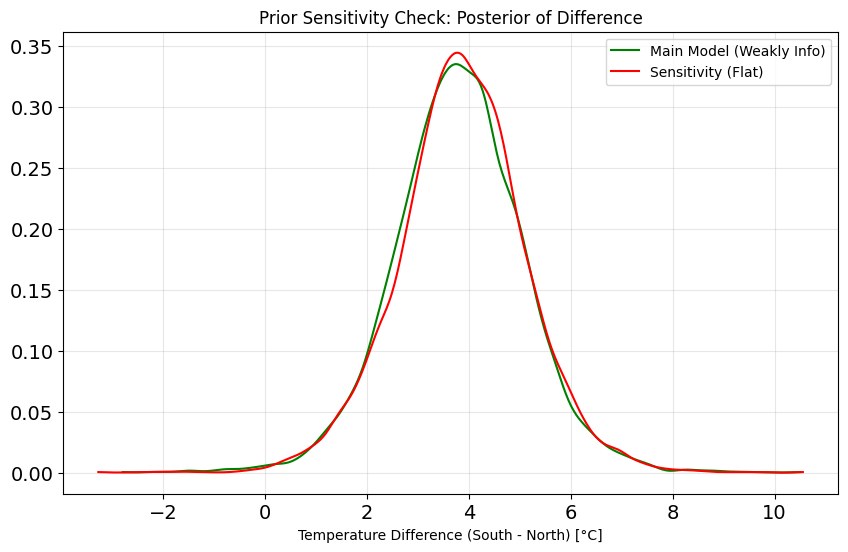

   -> Sensitivity Plot displayed.

[Step 4] Inference & ROPE Analysis
   -> ROPE Interval defined as: [-0.5°C, 0.5°C]


<Figure size 1000x600 with 0 Axes>

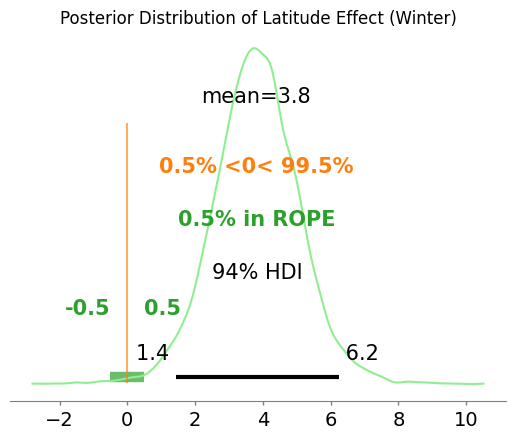

   -> ROPE Plot displayed.
   -> P(Difference > 0.5°C): 0.9915
   -> P(Inside ROPE): 0.0054

[Step 5] Final Conclusion (Based on 95% threshold)
   ✅ CONCLUSION: Significant Latitude Effect.
   The probability that Southern stations are practically warmer (>0.5°C diff) is > 95%.

[Step 6] Frequentist Sanity Check (Welch's T-Test)
   -> T-Statistic: 3.8246
   -> P-Value: 3.3625e-03
   -> Frequentist Result: Significant Difference (p < 0.05)

[Step 7] Custom Posterior Predictive Check
   -> Generating synthetic datasets from posterior trace...


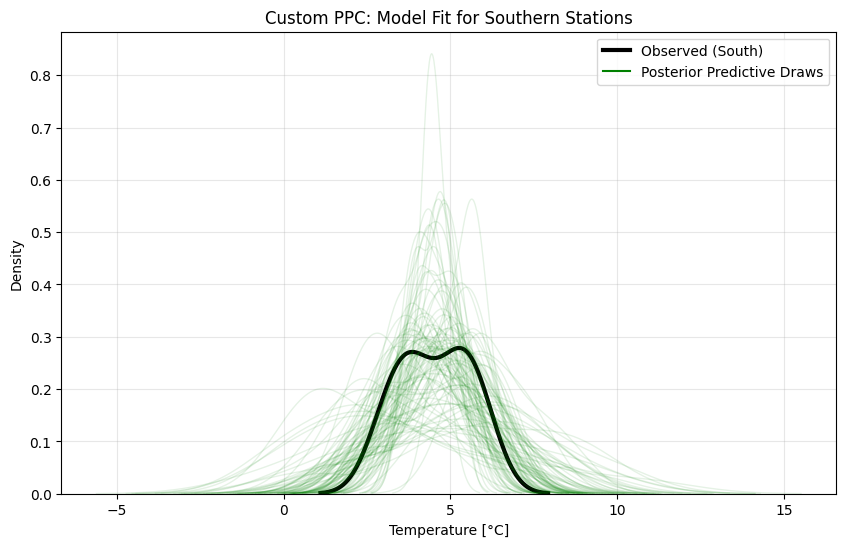

   -> PPC Plot displayed.

Analysis Run Complete.


In [24]:
print("\n[Step 1] Data Preparation & Grouping")

# 1. Filter for Winter Months (Dec=12, Jan=1, Feb=2)
df_winter = df[df['month'].isin([12, 1, 2])].copy()

# 2. Define Groups by Median Latitude Split
median_lat = df_winter['latitude'].median()

# Aggregate average winter temperature per station (Unit of Analysis = Station)
station_winter_avg = df_winter.groupby(['station', 'latitude'])['temperature'].mean().reset_index()

# Split into South (Lat <= Median) and North (Lat > Median)
group_south = station_winter_avg[station_winter_avg['latitude'] <= median_lat]['temperature'].values
group_north = station_winter_avg[station_winter_avg['latitude'] > median_lat]['temperature'].values

print(f"   -> Split Criterion: Median Latitude {median_lat:.4f}°N")
print(f"   -> Southern Group (n={len(group_south)}): Mean = {np.mean(group_south):.2f}°C")
print(f"   -> Northern Group (n={len(group_north)}): Mean = {np.mean(group_north):.2f}°C")

# ==========================================
# 3. BAYESIAN MODELING
# ==========================================
print("\n[Step 2] Bayesian Model Construction (BEST)")
print("   -> Likelihood: Normal(mu, sigma)")
print("   -> Priors: mu ~ Normal(0, 10), sigma ~ HalfNormal(10)")

def run_bayesian_model(g1, g2, prior_mu_sd=10, prior_sigma_sd=10, label="Standard"):
    with pm.Model() as model:
        # --- Priors ---
        # Weakly informative priors centered at 0C
        mu_south = pm.Normal("mu_south", mu=0, sigma=prior_mu_sd)
        mu_north = pm.Normal("mu_north", mu=0, sigma=prior_mu_sd)
        
        # Standard deviations
        sigma_south = pm.HalfNormal("sigma_south", sigma=prior_sigma_sd)
        sigma_north = pm.HalfNormal("sigma_north", sigma=prior_sigma_sd)
        
        # --- Likelihood ---
        obs_south = pm.Normal("obs_south", mu=mu_south, sigma=sigma_south, observed=g1)
        obs_north = pm.Normal("obs_north", mu=mu_north, sigma=sigma_north, observed=g2)
        
        # --- Deterministic ---
        # Difference: South - North
        diff_means = pm.Deterministic("diff_means", mu_south - mu_north)
        
        # --- Sampling ---
        # Using 2000 draws to ensure stable probabilities
        trace = pm.sample(2000, tune=1000, return_inferencedata=True, progressbar=False)
    
    return model, trace

# Run Main Model
model_main, trace_main = run_bayesian_model(group_south, group_north, label="Main Model")

# ==========================================
# 4. PRIOR SENSITIVITY ANALYSIS
# ==========================================
print("\n[Step 3] Prior Sensitivity Analysis")
print("   -> Running model with Flat Priors (SD=100) to check robustness...")

# Run Sensitivity Model
model_sens, trace_sens = run_bayesian_model(group_south, group_north, prior_mu_sd=100, prior_sigma_sd=100, label="Sensitivity")

# Calculate means of posterior means for comparison
mean_diff_main = trace_main.posterior["diff_means"].mean().item()
mean_diff_sens = trace_sens.posterior["diff_means"].mean().item()

print(f"   -> Main Model Mean Diff: {mean_diff_main:.3f}°C")
print(f"   -> Sensitivity Model Mean Diff: {mean_diff_sens:.3f}°C")

# Visual Comparison
plt.figure(figsize=(10, 6))
az.plot_dist(trace_main.posterior["diff_means"], label="Main Model (Weakly Info)", color="green")
az.plot_dist(trace_sens.posterior["diff_means"], label="Sensitivity (Flat)", color="red")
plt.title("Prior Sensitivity Check: Posterior of Difference")
plt.xlabel("Temperature Difference (South - North) [°C]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print("   -> Sensitivity Plot displayed.")

# ==========================================
# 5. POSTERIOR INFERENCE & ROPE
# ==========================================
print("\n[Step 4] Inference & ROPE Analysis")
# ROPE Definition: [-0.5, 0.5]
rope_low, rope_high = -0.5, 0.5
print(f"   -> ROPE Interval defined as: [{rope_low}°C, {rope_high}°C]")

# Plotting Posterior with ROPE
plt.figure(figsize=(10, 6))
az.plot_posterior(
    trace_main, 
    var_names=["diff_means"], 
    ref_val=0, 
    rope=[rope_low, rope_high],
    color='lightgreen'
)
plt.title("Posterior Distribution of Latitude Effect (Winter)")
plt.show()
print("   -> ROPE Plot displayed.")

# Probability Calculations
posterior_diff = trace_main.posterior["diff_means"].values.flatten()
prob_positive = (posterior_diff > rope_high).mean() # Probability South is strictly warmer
prob_rope = ((posterior_diff >= rope_low) & (posterior_diff <= rope_high)).mean() # Probability of equivalence

print(f"   -> P(Difference > {rope_high}°C): {prob_positive:.4f}")
print(f"   -> P(Inside ROPE): {prob_rope:.4f}")

# DECISION RULES (Matches Markdown)
print("\n[Step 5] Final Conclusion (Based on 95% threshold)")
if prob_positive > 0.95:
    print("   ✅ CONCLUSION: Significant Latitude Effect.")
    print("   The probability that Southern stations are practically warmer (>0.5°C diff) is > 95%.")
elif prob_rope > 0.95:
    print("   ✅ CONCLUSION: Practical Equivalence.")
    print("   The probability that the difference is negligible is > 95%.")
else:
    print("   ⚠️ CONCLUSION: Inconclusive.")
    print("   The posterior density is not concentrated enough inside or outside the ROPE.")

# ==========================================
# 6. FREQUENTIST CHECK
# ==========================================
print("\n[Step 6] Frequentist Sanity Check (Welch's T-Test)")
t_stat, p_val = stats.ttest_ind(group_south, group_north, equal_var=False)
print(f"   -> T-Statistic: {t_stat:.4f}")
print(f"   -> P-Value: {p_val:.4e}")
if p_val < 0.05:
    print("   -> Frequentist Result: Significant Difference (p < 0.05)")
else:
    print("   -> Frequentist Result: Not Significant")

# ==========================================
# 7. CUSTOM PPC
# ==========================================
print("\n[Step 7] Custom Posterior Predictive Check")
print("   -> Generating synthetic datasets from posterior trace...")

mu_samples = trace_main.posterior['mu_south'].values.flatten()
sigma_samples = trace_main.posterior['sigma_south'].values.flatten()

plt.figure(figsize=(10, 6))
# Observed Data
sns.kdeplot(group_south, color='black', linewidth=3, label='Observed (South)')

# Posterior Predictive Samples
n_ppc_samples = 100
n_obs = len(group_south)
ppc_indices = np.random.choice(len(mu_samples), n_ppc_samples, replace=False)

for idx in ppc_indices:
    sim_data = np.random.normal(loc=mu_samples[idx], scale=sigma_samples[idx], size=n_obs)
    sns.kdeplot(sim_data, color='green', alpha=0.1, linewidth=1)

plt.plot([], [], color='green', label='Posterior Predictive Draws')
plt.title("Custom PPC: Model Fit for Southern Stations")
plt.xlabel("Temperature [°C]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print("   -> PPC Plot displayed.")
print("\nAnalysis Run Complete.")

# Regression